### Import needed libraries

In [378]:
import requests
import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

In [379]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns

### Obtain list of all activities

In [380]:

auth_url = "https://www.strava.com/oauth/token"
activities_url = "https://www.strava.com/api/v3/athlete/activities"

payload = {
    'client_id': "xxxx",
    'client_secret': 'xxxx',
    'refresh_token': 'xxxx',
    'grant_type': "refresh_token",
    'f': 'json'
}

print("Requesting Token...\n")
res = requests.post(auth_url, data=payload, verify=False)
access_token = res.json()['access_token']
print("Access Token = {}\n".format(access_token))

print("Requesting pages (200 activities per full page)...")
activities_df = pd.DataFrame()
page = 1
page_non_empty = True
while page_non_empty:
    header = {'Authorization': 'Bearer ' + access_token}
    param = {'per_page': 200, 'page': page}
    my_activities = requests.get(activities_url, headers=header, params=param).json()
    activities_df = activities_df.append(my_activities, ignore_index=True)
    page_non_empty = bool(my_activities)
    print(page)
    page += 1

print("\n", len(activities_df), "activities downloaded")

Requesting Token...

Access Token = 302a2fcc1edcea4e6ca13f2d6fb682dba5544e15

Requesting pages (200 activities per full page)...
1
2
3

 300 activities downloaded


### Clean Data

In [381]:
activities_df.columns

Index(['resource_state', 'athlete', 'name', 'distance', 'moving_time',
       'elapsed_time', 'total_elevation_gain', 'type', 'workout_type', 'id',
       'external_id', 'upload_id', 'start_date', 'start_date_local',
       'timezone', 'utc_offset', 'start_latlng', 'end_latlng', 'location_city',
       'location_state', 'location_country', 'start_latitude',
       'start_longitude', 'achievement_count', 'kudos_count', 'comment_count',
       'athlete_count', 'photo_count', 'map', 'trainer', 'commute', 'manual',
       'private', 'visibility', 'flagged', 'gear_id', 'from_accepted_tag',
       'upload_id_str', 'average_speed', 'max_speed', 'average_cadence',
       'average_temp', 'average_watts', 'kilojoules', 'device_watts',
       'has_heartrate', 'average_heartrate', 'max_heartrate',
       'heartrate_opt_out', 'display_hide_heartrate_option', 'elev_high',
       'elev_low', 'pr_count', 'total_photo_count', 'has_kudoed'],
      dtype='object')

In [382]:
activities_df.shape

(300, 55)

#### Get Columns I want to use

In [383]:
cols = ['name', 'type', 'distance', 'moving_time',   
         'average_speed', 'max_speed', "average_cadence", 'total_elevation_gain',
         'start_date_local', "kudos_count" 
       ]

activities = activities_df[cols]

In [384]:
# Convert to datetime
activities['start_date_local'] = pd.to_datetime(activities['start_date_local'])
activities['start_time'] = activities['start_date_local'].dt.time
activities['start_date_local'] = activities['start_date_local'].dt.date
activities = activities.rename({'start_date_local':'start_date'}, axis='columns')
#Move kudos to last column
temp = activities.pop("kudos_count")
activities["kudos_count"] = temp

activities.head()

,name,type,distance,moving_time,average_speed,max_speed,average_cadence,total_elevation_gain,start_date,start_time,kudos_count
0,Bicicleta por la mañana,Ride,81719.3,10934,7.474,16.8,83.7,662.0,2021-08-28,09:52:17,70
1,Bicicleta por la mañana,Ride,76459.2,10130,7.548,16.1,82.1,418.0,2021-08-27,08:54:09,66
2,Caminata de mañana,Walk,5702.8,3852,1.480,6.8,59.7,18.7,2021-08-26,09:52:58,39
3,Bicicleta por la mañana,Ride,97568.4,11708,8.333,17.4,78.4,697.0,2021-08-20,09:05:57,87
4,La Oficial +,Ride,105094.0,14918,7.045,17.9,79.6,1008.0,2021-08-15,09:06:18,73


#### Divide Data in DF by Sport: Bike/Run.   Ignore walk

In [385]:
#Convert m/s speeds to Km/h and min/km for cycling/running
def to_km_h(m_s):
    return m_s * 3600 / 1000

def to_min_km(m_s):
    s_m = 1 / m_s
    return(s_m * 1000 / 60) 

In [386]:
cycling = activities[activities.type == "Ride"]
running = activities[activities.type == "Run"]

In [387]:
cycling["average_speed"] = to_km_h(cycling["average_speed"])
cycling["max_speed"] = to_km_h(cycling["max_speed"])
running["average_speed"] = to_min_km(running["average_speed"])
running["max_speed"] = to_min_km(running["max_speed"])

In [388]:
print(cycling.shape)
cycling.head()

(181, 11)


,name,type,distance,moving_time,average_speed,max_speed,average_cadence,total_elevation_gain,start_date,start_time,kudos_count
0,Bicicleta por la mañana,Ride,81719.3,10934,26.9064,60.48,83.7,662.0,2021-08-28,09:52:17,70
1,Bicicleta por la mañana,Ride,76459.2,10130,27.1728,57.96,82.1,418.0,2021-08-27,08:54:09,66
3,Bicicleta por la mañana,Ride,97568.4,11708,29.9988,62.64,78.4,697.0,2021-08-20,09:05:57,87
4,La Oficial +,Ride,105094.0,14918,25.3620,64.44,79.6,1008.0,2021-08-15,09:06:18,73
5,Bicicleta por la mañana,Ride,100520.0,12634,28.6416,52.20,85.4,411.0,2021-08-13,09:05:06,78


In [389]:
print(cycling.shape)
cycling.head()

(181, 11)


,name,type,distance,moving_time,average_speed,max_speed,average_cadence,total_elevation_gain,start_date,start_time,kudos_count
0,Bicicleta por la mañana,Ride,81719.3,10934,26.9064,60.48,83.7,662.0,2021-08-28,09:52:17,70
1,Bicicleta por la mañana,Ride,76459.2,10130,27.1728,57.96,82.1,418.0,2021-08-27,08:54:09,66
3,Bicicleta por la mañana,Ride,97568.4,11708,29.9988,62.64,78.4,697.0,2021-08-20,09:05:57,87
4,La Oficial +,Ride,105094.0,14918,25.3620,64.44,79.6,1008.0,2021-08-15,09:06:18,73
5,Bicicleta por la mañana,Ride,100520.0,12634,28.6416,52.20,85.4,411.0,2021-08-13,09:05:06,78


# And finally... some basic Data Analysis!! :)

### Do I go slower when I run further?

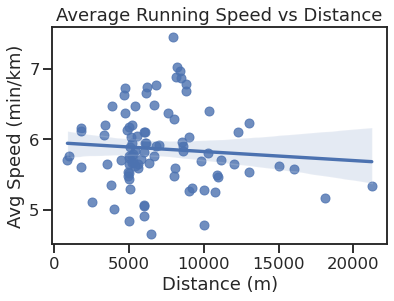

In [390]:
sns.set(style="ticks", context="talk")
ax = sns.regplot(x='distance', y = 'average_speed', data = running)
plt.title("Average Running Speed vs Distance")
plt.xlabel("Distance (m)")
plt.ylabel("Avg Speed (min/km)")
plt.show()

So basically no, I run almost at the same Avg speed for every distance

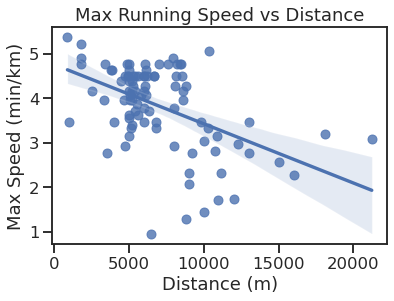

In [391]:
sns.set(style="ticks", context="talk")
ax = sns.regplot(x='distance', y = 'max_speed', data = running)
plt.title("Max Running Speed vs Distance")
plt.xlabel("Distance (m)")
plt.ylabel("Max Speed (min/km)")
plt.show()

We can clearly see that shorter runs have a higher max speed (usually shorter runs = interval runs)

### Do I go slower when I cycle further?

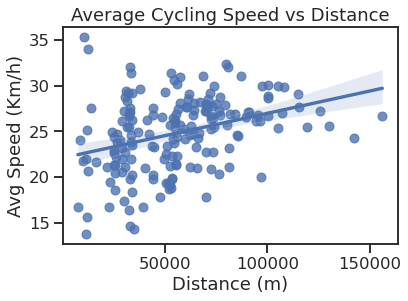

In [392]:
sns.set(style="ticks", context="talk")
ax = sns.regplot(x='distance', y = 'average_speed', data = cycling)
plt.title("Average Cycling Speed vs Distance")
plt.xlabel("Distance (m)")
plt.ylabel("Avg Speed (Km/h)")
plt.show()

We can see that the days that I cycle further, my avg speed goes up. That can be related to going with more ppl when I do long cycling sessions, which does help to increase speed

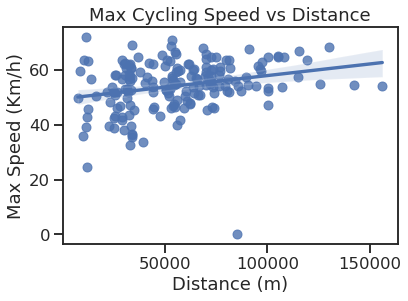

In [393]:
sns.set(style="ticks", context="talk")
ax = sns.regplot(x='distance', y = 'max_speed', data = cycling)
plt.title("Max Cycling Speed vs Distance")
plt.xlabel("Distance (m)")
plt.ylabel("Max Speed (Km/h)")
plt.show()

And again, longer sessions tend to have higher max speeds (going downhill with more ppl motivates me to go faster that when I'm on my own)

### Time to check if I have gotten faster over time!

#### Running

/tmp/ipykernel_101216/3252440110.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


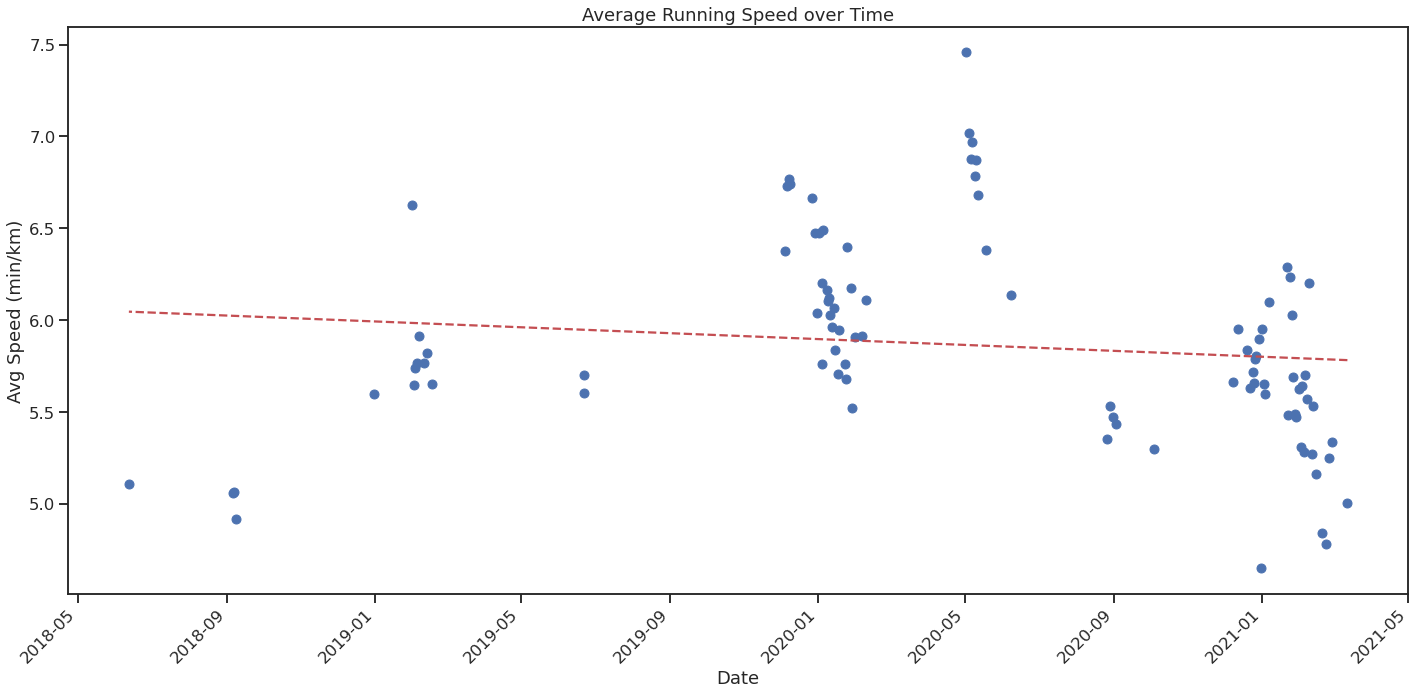

In [394]:
import matplotlib.dates as mdates

fig = plt.figure(figsize=(20,10)) 
ax1 = fig.add_subplot(111) #add a 1 by 1 plot to the figure
x = np.asarray(running.start_date)  #convert data to numpy array
y = np.asarray(running.average_speed)
ax1.plot_date(x, y) #plot data points in scatter plot on ax1
ax1.set_title('Average Running Speed over Time')
ax1.set_xlabel("Date")
ax1.set_ylabel("Avg Speed (min/km)")
#ax1.set_ylim([0,5])
#add trend line
x2 = mdates.date2num(x)
z=np.polyfit(x2,y,1)
p=np.poly1d(z)
plt.plot(x,p(x2),'r--')
#format the figure and display
fig.autofmt_xdate(rotation=45)
fig.tight_layout()
fig.show()

Theres been some improvement but not really a lot :( Gotta run more often and not quit folks!

#### Cycling

/tmp/ipykernel_101216/3732034981.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


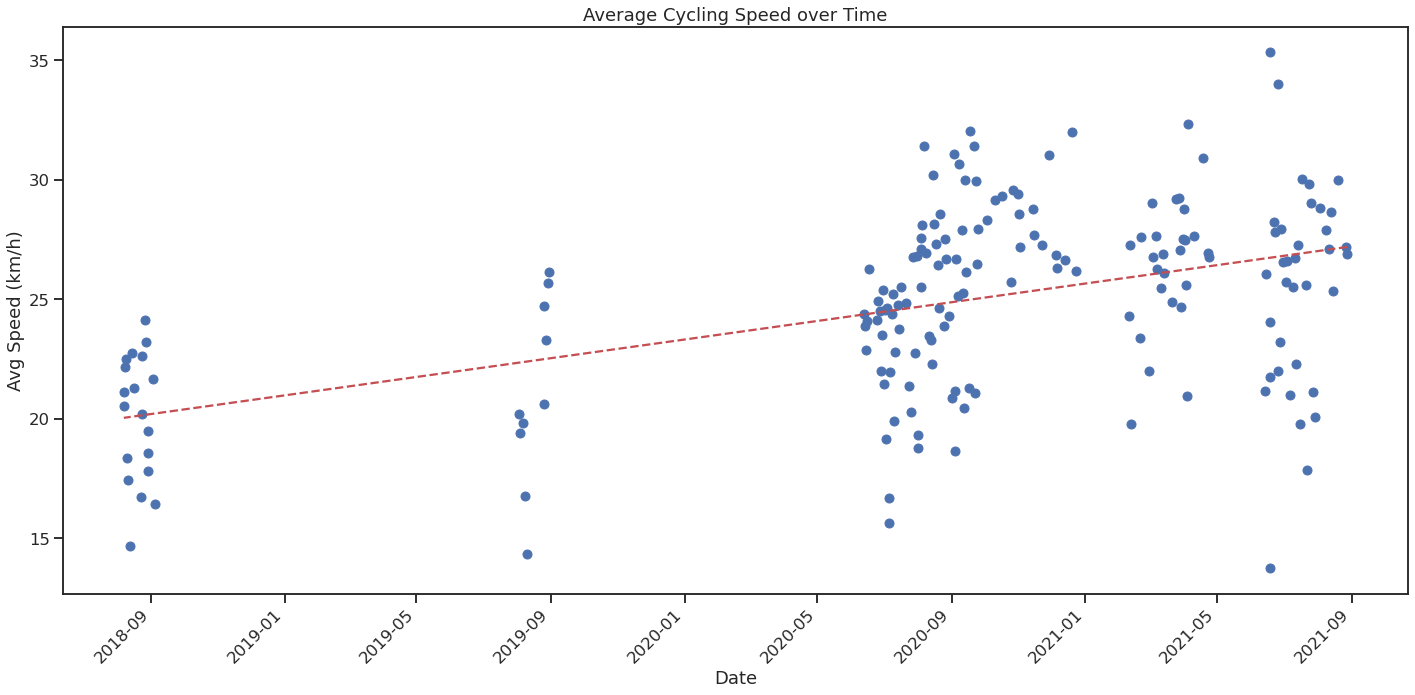

In [395]:
import matplotlib.dates as mdates

fig = plt.figure(figsize=(20,10)) 
ax1 = fig.add_subplot(111) #add a 1 by 1 plot to the figure
x = np.asarray(cycling.start_date)  #convert data to numpy array
y = np.asarray(cycling.average_speed)
ax1.plot_date(x, y) #plot data points in scatter plot on ax1
ax1.set_title('Average Cycling Speed over Time')
ax1.set_xlabel("Date")
ax1.set_ylabel("Avg Speed (km/h)")
#ax1.set_ylim([0,5])
#add trend line
x2 = mdates.date2num(x)
z=np.polyfit(x2,y,1)
p=np.poly1d(z)
plt.plot(x,p(x2),'r--')
#format the figure and display
fig.autofmt_xdate(rotation=45)
fig.tight_layout()
fig.show()

Now, here we got some improvement!! Fast as fk boiiii

### Time to analyze Cadence
Cadence should go up when you train and ideally be around 170-190 (running) or 85-90 (cycling)

In [396]:
# First we have to drop NaN rows cause I don't always analyze my cadence when I run or cycle
running_c = running[running['average_cadence'].notna()]
cycling_c = cycling[cycling['average_cadence'].notna()]

/tmp/ipykernel_101216/369459174.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


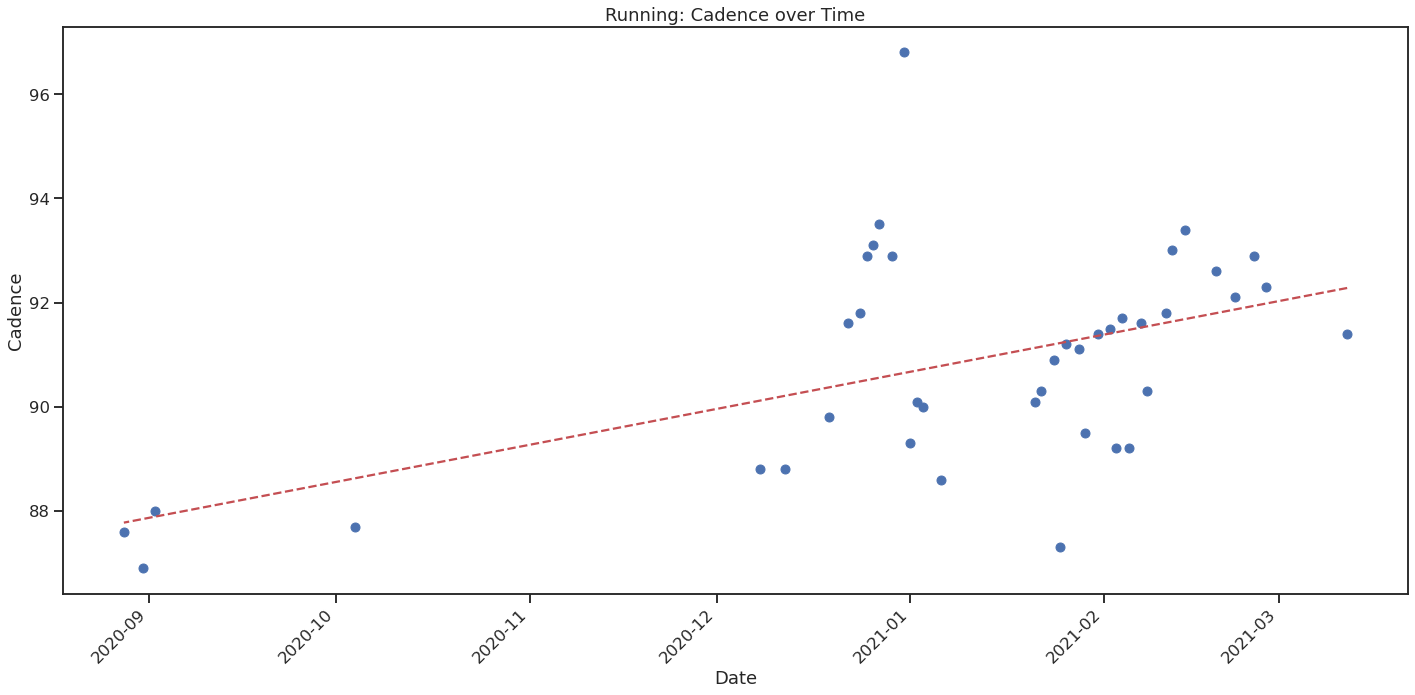

In [397]:
import matplotlib.dates as mdates

fig = plt.figure(figsize=(20,10)) 
ax1 = fig.add_subplot(111) #add a 1 by 1 plot to the figure
x = np.asarray(running_c.start_date)  #convert data to numpy array
y = np.asarray(running_c['average_cadence'])
ax1.plot_date(x, y) #plot data points in scatter plot on ax1
ax1.set_title('Running: Cadence over Time')
ax1.set_xlabel("Date")
ax1.set_ylabel("Cadence")
#ax1.set_ylim([0,5])
#add trend line
x2 = mdates.date2num(x)
z=np.polyfit(x2,y,1)
p=np.poly1d(z)
plt.plot(x,p(x2),'r--')
#format the figure and display
fig.autofmt_xdate(rotation=45)
fig.tight_layout()
fig.show()

As we can see cadence has gone up from 88 to 92 over time so thats pretty good!

/tmp/ipykernel_101216/1695010859.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


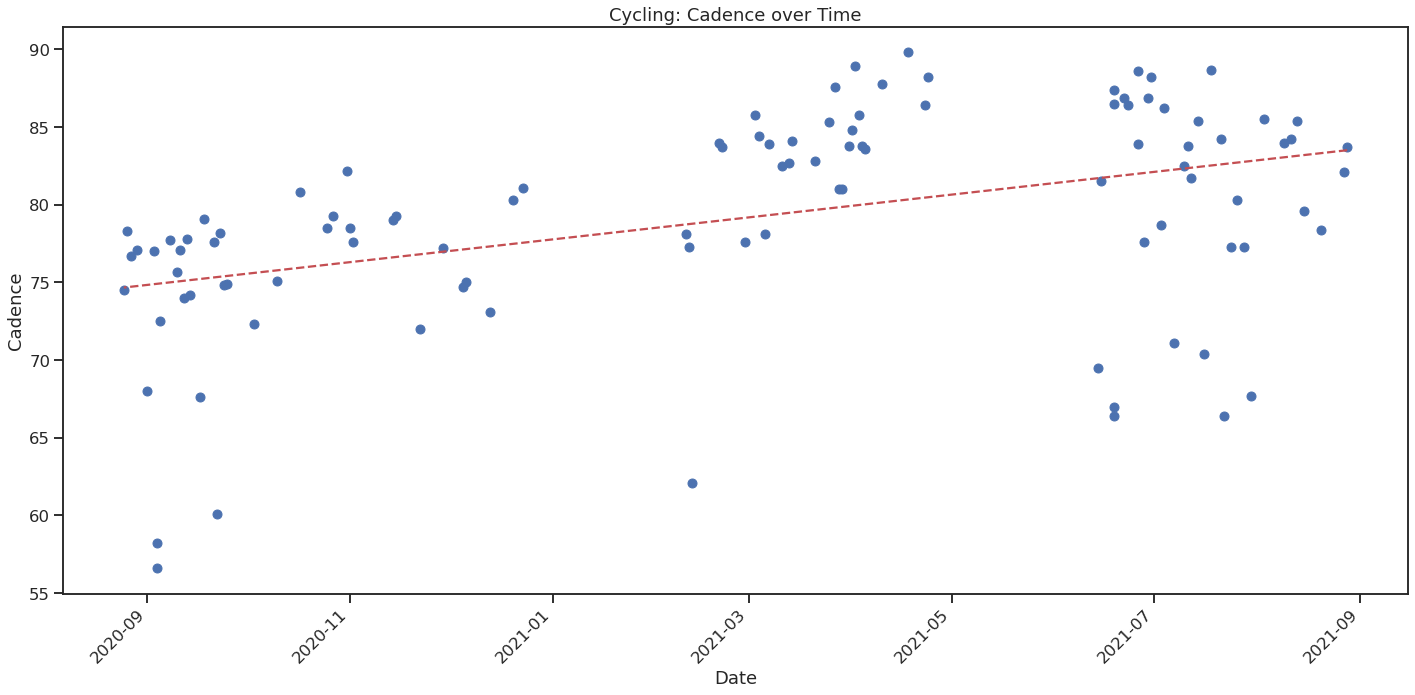

In [398]:
import matplotlib.dates as mdates

fig = plt.figure(figsize=(20,10)) 
ax1 = fig.add_subplot(111) #add a 1 by 1 plot to the figure
x = np.asarray(cycling_c.start_date)  #convert data to numpy array
y = np.asarray(cycling_c.average_cadence)
ax1.plot_date(x, y) #plot data points in scatter plot on ax1
ax1.set_title('Cycling: Cadence over Time')
ax1.set_xlabel("Date")
ax1.set_ylabel("Cadence")
#ax1.set_ylim([0,5])
#add trend line
x2 = mdates.date2num(x)
z=np.polyfit(x2,y,1)
p=np.poly1d(z)
plt.plot(x,p(x2),'r--')
#format the figure and display
fig.autofmt_xdate(rotation=45)
fig.tight_layout()
fig.show()

Again we can see that cadence has gone up to around 85, so thats also pretty good!

### Do I go slower with more elevation gained when cycling? Let's find out!

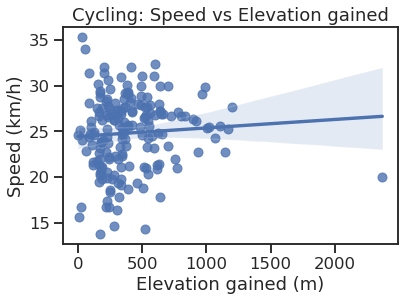

In [399]:
sns.set(style="ticks", context="talk")
ax = sns.regplot(x='total_elevation_gain', y = 'average_speed', data = cycling)
plt.title("Cycling: Speed vs Elevation gained")
plt.xlabel("Elevation gained (m)")
plt.ylabel("Speed (km/h)")
plt.show()

Not really.
Just wanna point out, the value with most el. gained (2.500 km) is a ride in Picos de Europa so it's not an outlier

### And finally, just for the lols, time to analyze if more distance = more kudos :P

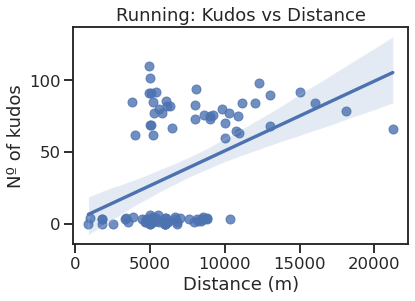

In [400]:
sns.set(style="ticks", context="talk")
ax = sns.regplot(x='distance', y = 'kudos_count', data = running)
plt.title("Running: Kudos vs Distance")
plt.xlabel("Distance (m)")
plt.ylabel("Nº of kudos")
plt.show()

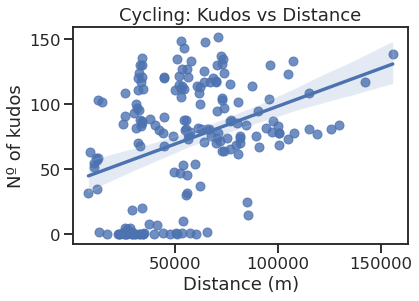

In [401]:
sns.set(style="ticks", context="talk")
ax = sns.regplot(x='distance', y = 'kudos_count', data = cycling)
plt.title("Cycling: Kudos vs Distance")
plt.xlabel("Distance (m)")
plt.ylabel("Nº of kudos")
plt.show()

So apparently more kms = more kudos. This data isn't really precise though, because all the runs/rides with 0 kudos were done at the start of my Strava account, so I had no friends in Strava and used to do shorter runs/rides cause I wasnt fit.

# Thank you for reading!
Hope you liked my work. Now, time to do some sports to gather more data!